In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split

from skimage.feature import hog
from skimage.measure import label



In [7]:
# Original DATASET
DATASET_PATH = "Dataset-for-miniproject"
OLIVE_FLY_DIR = os.path.join(DATASET_PATH, "olive_fly")
NOT_OLIVE_FLY_DIR = os.path.join(DATASET_PATH, "not_olive_fly")

# New and balanced
NEW_DATASET_PATH = "data_balanced"
NEW_OLIVE_DIR = os.path.join(NEW_DATASET_PATH, "olive_fly")
NEW_NOT_OLIVE_DIR = os.path.join(NEW_DATASET_PATH, "not_olive_fly")

IMG_SIZE = (170, 170)


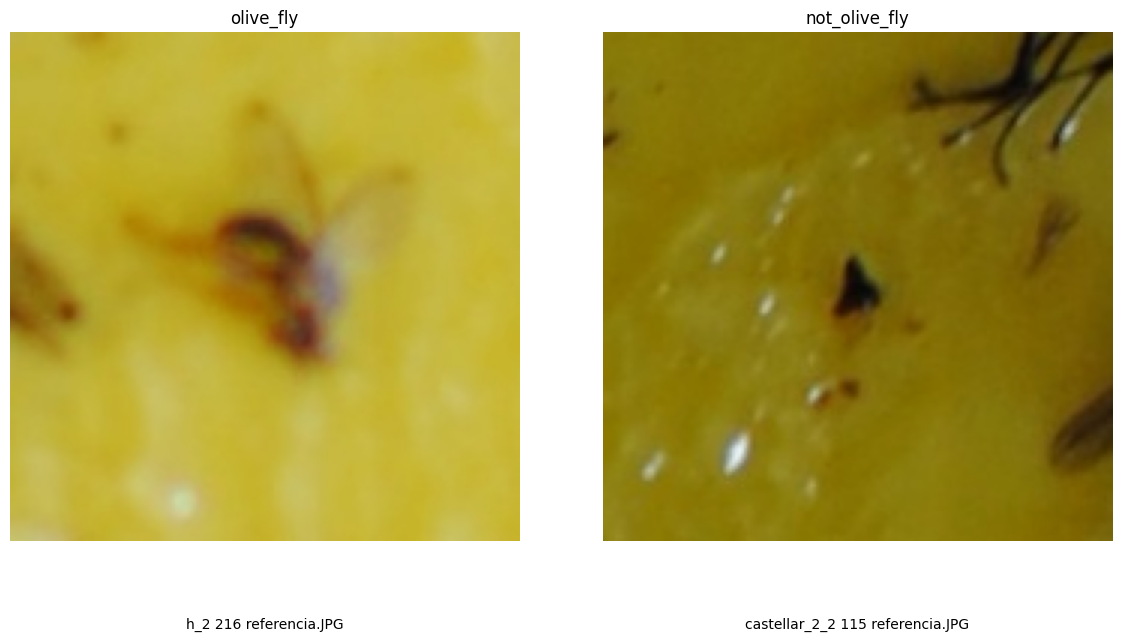

In [8]:
def show_two_samples(olive_dir, not_olive_dir):
    def pick_image(d):
        files = [f for f in os.listdir(d) if os.path.isfile(os.path.join(d, f))]
        if not files:
            raise ValueError(f"No images found in {d}")
        return os.path.join(d, random.choice(files))

    o_path = pick_image(olive_dir)
    n_path = pick_image(not_olive_dir)

    o = cv2.cvtColor(cv2.imread(o_path), cv2.COLOR_BGR2RGB)
    n = cv2.cvtColor(cv2.imread(n_path), cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(o)
    axes[0].axis("off")
    axes[0].set_title("olive_fly")
    axes[0].text(0.5, -0.15, os.path.basename(o_path), size=10, ha="center", va="top", transform=axes[0].transAxes)

    axes[1].imshow(n)
    axes[1].axis("off")
    axes[1].set_title("not_olive_fly")
    axes[1].text(0.5, -0.15, os.path.basename(n_path), size=10, ha="center", va="top", transform=axes[1].transAxes)

    plt.tight_layout()
    plt.show()
    
show_two_samples(OLIVE_FLY_DIR, NOT_OLIVE_FLY_DIR)

## Foreground extraction

In [9]:
def extract_foreground(img, kernel_size=9, background_color=255) :
    """
    Extract the foreground from an image. Works by assuming we are looking
    for something dark on a light background. It does an inverse Otsu
    threshold to get a binary image. This is cleaned by morphological closing. 
    Finally, we select the largest connected component by labelling and sorting.
    
    @param img: the image to be processed. Should be three channel image.
    @param kernel_size: kernel size for Morphological closing.
        Larger values will result in less noise, but lower resolution masks.
    @param background color. All parts of the image not in the foreground
    will be replaced by this color. Can also be a tuple eg: (255,255,0)

    returns two matrices: the foreground and a mask. 
    """
    # convert to grayscale, and make sure result is 8 bit
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.uint8)
    
    # use inverse OTSU threshold to get the dark parts (likely insects)
    thresh, img_bw = cv2.threshold(img_gray,-1, 255,
                                   cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # cleanup a bit with morphological closing
    kernel = np.ones((kernel_size, kernel_size))
    img_bw_cleaned = cv2.morphologyEx(img_bw, cv2.MORPH_CLOSE, kernel)
    
    # label with skimage
    labels = label(img_bw_cleaned)
    
    # get the largest labeled region, other than the background
    label_of_largest_region = np.argmax(np.bincount(labels.flat, 
                                                    weights=img_bw_cleaned.flat))
    largest_region = labels == label_of_largest_region
    

    # apply largest region as mask
    x, y = np.where(np.invert(largest_region))
    foreground = img.copy()
    foreground[x,y] = background_color
    
    return foreground, largest_region
    
    
    

In [10]:
def process_folder(
    input_dir,
    output_dir,
    img_size=(170, 170),
    background_color=255
):
    os.makedirs(output_dir, exist_ok=True)

    for img_name in os.listdir(input_dir):
        src_path = os.path.join(input_dir, img_name)

        if not os.path.isfile(src_path):
            continue

        img = cv2.imread(src_path)
        if img is None:
            continue

        img = cv2.resize(img, img_size)

        foreground, mask = extract_foreground(
            img,
            kernel_size=9,
            background_color=background_color
        )

        dst_path = os.path.join(output_dir, img_name)
        cv2.imwrite(dst_path, foreground)

In [11]:
# Process olive_fly images
process_folder(
    input_dir=OLIVE_FLY_DIR,
    output_dir=NEW_OLIVE_DIR,
    img_size=IMG_SIZE
)

# Process not_olive_fly images
process_folder(
    input_dir=NOT_OLIVE_FLY_DIR,
    output_dir=NEW_NOT_OLIVE_DIR,
    img_size=IMG_SIZE
)

print("Foreground extraction applied to all images.")

Foreground extraction applied to all images.


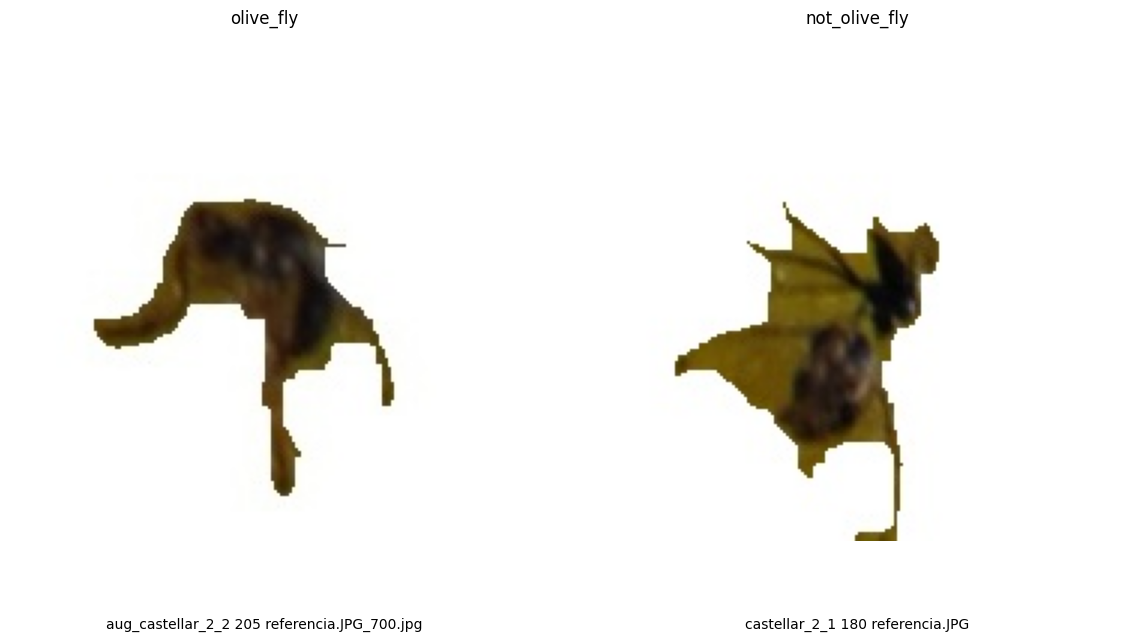

In [12]:
show_two_samples(NEW_OLIVE_DIR, NEW_NOT_OLIVE_DIR)

Check for bad foreground extraction on images by calculating foreground ratio <br>
Finding sweetspot of foreground ratio within the dataset and setting threshold to delete bad extracted images that have too much (non white) background

In [13]:
IMG_FOLDERS = {
    "olive_fly": "data_balanced/olive_fly",
    "not_olive_fly": "data_balanced/not_olive_fly"
}

BACKGROUND_VALUE = 255
TOL = 5  
SAMPLES_TO_SHOW = 2  # amount of samples of bad images to show
THRESHOLD_OLIVE = 0.35  # max fraction foreground pixels
THRESHOLD_NOT = 0.20

In [14]:
def foreground_ratio(img, background_value=BACKGROUND_VALUE, tol=TOL):
    # calculate fraction foreground pixels (not almost white)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    fg_pixels = np.sum(gray < (background_value - tol))
    total_pixels = gray.size
    return fg_pixels / total_pixels

def compute_ratios_for_folder(folder):
    # calculate foreground ratios for all images in a folder.
    ratios = []
    files = []
    for f in os.listdir(folder):
        path = os.path.join(folder, f)
        if not f.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        if not os.path.isfile(path):
            continue
        img = cv2.imread(path)
        if img is None:
            print("Could not read:", f)
            continue
        r = foreground_ratio(img)
        ratios.append(r)
        files.append(f)
    print(f"Processed {len(ratios)} images from folder {folder}")
    return np.array(ratios), files

def visualize_bad_samples(folder, ratios, files, threshold, num_samples=SAMPLES_TO_SHOW):
    plt.figure(figsize=(6,4))
    plt.hist(ratios, bins=30)
    plt.xlabel("Foreground ratio")
    plt.ylabel("")
    plt.title(f"Foreground ratio distribution ({os.path.basename(folder)})")
    plt.show()
    
    print(f"Min ratio: {ratios.min():.3f}, Mean: {ratios.mean():.3f}, Max: {ratios.max():.3f}")
    
    # Select bad samples, ratio above threshold
    bad_indices = np.where(ratios > threshold)[0]
    print(f"Amount of images above threshold (> {threshold}): {len(bad_indices)}")
    
    # Random samples from bad indices
    if len(bad_indices) > 0:
        sample_indices = random.sample(list(bad_indices), min(num_samples, len(bad_indices)))
        plt.figure(figsize=(6,3))
        for i, idx in enumerate(sample_indices):
            img = cv2.imread(os.path.join(folder, files[idx]))
            plt.subplot(1, len(sample_indices), i+1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"ratio={ratios[idx]:.3f}")
            plt.axis("off")
        plt.show()
    
    return bad_indices

In [15]:
def remove_bad_images(folder, files, bad_indices):
    for idx in bad_indices:
        os.remove(os.path.join(folder, files[idx]))
    print(f"Folder {folder} cleaned. Remaining images: {len(os.listdir(folder))}")
    print("------------------------------------------------------")


Processed 1005 images from folder data_balanced/olive_fly
Processed 2035 images from folder data_balanced/not_olive_fly
=== Olive Fly Folder ===


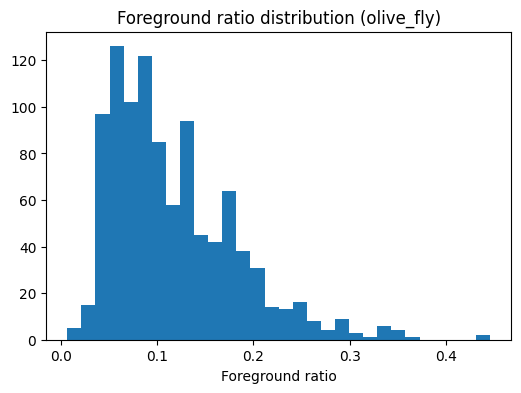

Min ratio: 0.007, Mean: 0.117, Max: 0.446
Amount of images above threshold (> 0.35): 5


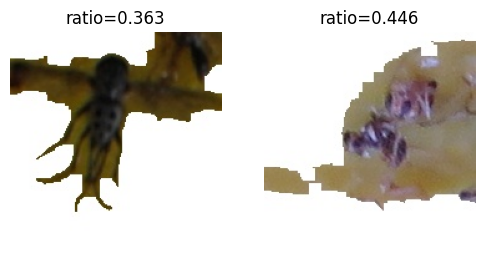

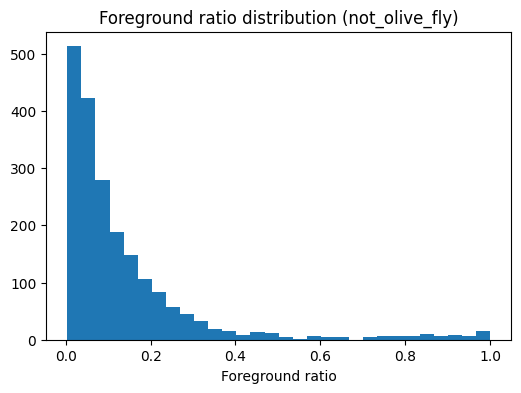

Min ratio: 0.003, Mean: 0.137, Max: 1.000
Amount of images above threshold (> 0.2): 388


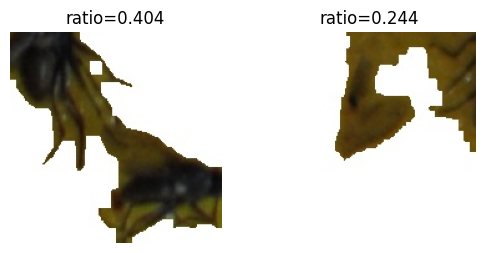

In [16]:
ratios_olive, files_olive = compute_ratios_for_folder(IMG_FOLDERS["olive_fly"])
ratios_not, files_not = compute_ratios_for_folder(IMG_FOLDERS["not_olive_fly"])

print("=== Olive Fly Folder ===")
bad_indices_olive = visualize_bad_samples(IMG_FOLDERS["olive_fly"], ratios_olive, files_olive, THRESHOLD_OLIVE)
bad_indices_not = visualize_bad_samples(IMG_FOLDERS["not_olive_fly"], ratios_not, files_not, THRESHOLD_NOT)

In [17]:
# delete bad extracted images with too much background
remove_bad_images(IMG_FOLDERS["olive_fly"], files_olive, bad_indices_olive)
remove_bad_images(IMG_FOLDERS["not_olive_fly"], files_not, bad_indices_not)

Folder data_balanced/olive_fly cleaned. Remaining images: 1000
------------------------------------------------------
Folder data_balanced/not_olive_fly cleaned. Remaining images: 1647
------------------------------------------------------


## Class distribution and Augmentation

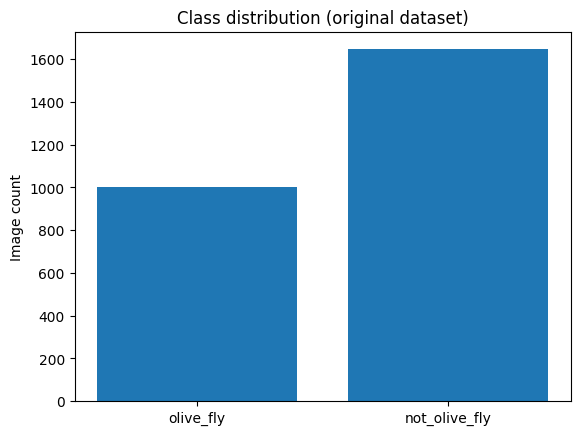

Olive fly: 1000
Not olive fly: 1647


In [18]:
olive_count = len(os.listdir(NEW_OLIVE_DIR))
not_olive_count = len(os.listdir(NEW_NOT_OLIVE_DIR))

plt.bar(["olive_fly", "not_olive_fly"], [olive_count, not_olive_count])
plt.title("Class distribution (original dataset)")
plt.ylabel("Image count")
plt.show()

print("Olive fly:", olive_count)
print("Not olive fly:", not_olive_count)


In [19]:
def augment_image(img):
    augmented = []

    # flip
    augmented.append(cv2.flip(img, 1))

    # rotations
    for angle in [-15, 15]:
        M = cv2.getRotationMatrix2D((15, 15), angle, 1)
        rotated = cv2.warpAffine(img, M, IMG_SIZE, borderValue=(255, 255, 255)) # white bg
        augmented.append(rotated)
        

    return augmented


In [20]:
TARGET_COUNT = 1000

olive_images = os.listdir(NEW_OLIVE_DIR)
current_count = len(olive_images)

idx = 0
while current_count < TARGET_COUNT:
    img_name = olive_images[idx % len(olive_images)]
    img_path = os.path.join(NEW_OLIVE_DIR, img_name)

    img = cv2.imread(img_path)
    img = cv2.resize(img, IMG_SIZE)

    aug_imgs = augment_image(img)

    for aug in aug_imgs:
        if current_count >= TARGET_COUNT:
            break
        save_path = os.path.join(
            NEW_OLIVE_DIR, f"aug_{img_name}_{current_count}.jpg"
        )
        cv2.imwrite(save_path, aug)
        current_count += 1

    idx += 1

print("New olive_fly count:", current_count)


New olive_fly count: 1000


In [21]:
files = [
    f for f in os.listdir(NEW_NOT_OLIVE_DIR)
    if os.path.isfile(os.path.join(NEW_NOT_OLIVE_DIR, f))
]

print("Before downsampling:", len(files))

# kies random TARGET_COUNT files om te behouden
keep_files = set(random.sample(files, TARGET_COUNT))

# verwijder alles wat niet gekozen is
for f in files:
    if f not in keep_files:
        os.remove(os.path.join(NEW_NOT_OLIVE_DIR, f))

print("After downsampling:", len(os.listdir(NEW_NOT_OLIVE_DIR)))

Before downsampling: 1647
After downsampling: 1000


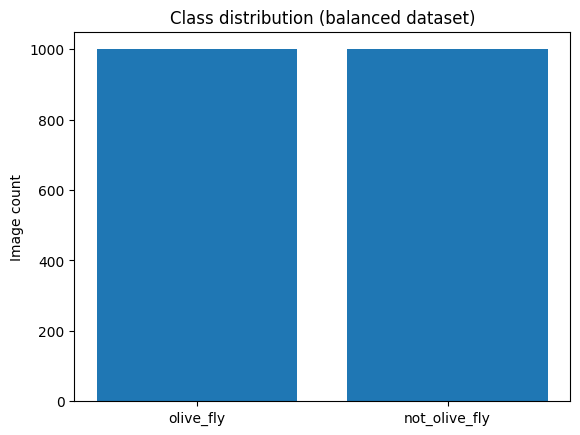

In [22]:
new_olive_count = len(os.listdir(NEW_OLIVE_DIR))
new_not_olive_count = len(os.listdir(NEW_NOT_OLIVE_DIR))

plt.bar(["olive_fly", "not_olive_fly"],
        [new_olive_count, new_not_olive_count])
plt.title("Class distribution (balanced dataset)")
plt.ylabel("Image count")
plt.show()


## Feature Extraction

### HOG Features
Extract shape and edge features

In [23]:
def extract_hog_features(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = gray / 255.0

    features = hog(
        gray,
        orientations=9,
        pixels_per_cell=(6, 6),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )
    return features


create hog feature dataset

In [24]:
X_hog = []
Y_hog = []

for label, folder in enumerate([NEW_NOT_OLIVE_DIR, NEW_OLIVE_DIR]):
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)

        features = extract_hog_features(img)
        X_hog.append(features)
        Y_hog.append(label)

X_hog = np.array(X_hog)
Y_hog = np.array(Y_hog)

In [25]:
print("x_shape:", X_hog.shape)
print("y_shape:", Y_hog.shape)

print(f"We have {X_hog.shape[0]} samples with {X_hog.shape[1]} features each.")
print(f"We have {Y_hog.shape[0]} labels. (each label is 0 or 1)")

x_shape: (2000, 26244)
y_shape: (2000,)
We have 2000 samples with 26244 features each.
We have 2000 labels. (each label is 0 or 1)


### Color Mapping 
Extract color features

In [26]:
def extract_color_histogram(img, bins=(8, 8, 8)):
    """
    Extract a color histogram from an image and normalize it.
    
    Parameters:
    - img: BGR image
    - bins: tuple, number of bins per channel (R,G,B)
    
    Returns:
    - 1D feature vector
    """
    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Compute 3D histogram
    hist = cv2.calcHist([img_rgb], [0,1,2], None, bins,
                        [0,256, 0,256, 0,256])
    
    # Normalize histogram
    hist = cv2.normalize(hist, hist).flatten()
    
    return hist


create color feature dataset

In [27]:
X_color = []
y_color = []

for label, folder in enumerate([NEW_NOT_OLIVE_DIR, NEW_OLIVE_DIR]):
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        
        features = extract_color_histogram(img, bins=(8,8,8))
        X_color.append(features)
        y_color.append(label)

X_color = np.array(X_color)
y_color = np.array(y_color)

In [28]:
print("x_color_shape:", X_color.shape)
print("y_color_shape:", y_color.shape)
print("Set has {x_color.shape[0]} samples with {x_color.shape[1]} (color) features each.")

x_color_shape: (2000, 512)
y_color_shape: (2000,)
Set has {x_color.shape[0]} samples with {x_color.shape[1]} (color) features each.


create dataset with both shape/edge features and color features combined

In [29]:
X_combined = []
y_combined = []

for label, folder in enumerate([NEW_NOT_OLIVE_DIR, NEW_OLIVE_DIR]):
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        
        hog_features = extract_hog_features(img)
        color_features = extract_color_histogram(img)
        
        combined = np.concatenate([hog_features, color_features])
        X_combined.append(combined)
        y_combined.append(label)  # label

# Convert to numpy arrays
X_combined = np.array(X_combined)
y_combined = np.array(y_combined)

print("X_combined shape:", X_combined.shape) # features: HOG + color
print("y_combined shape:", y_combined.shape) # 0 for not_olive_fly, 1 for olive_fly


X_combined shape: (2000, 26756)
y_combined shape: (2000,)


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
  X_combined, y_combined, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

np.savez('olive_data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

print("Data saved to olive_data.npz!")

Training set: 1600 samples
Test set: 400 samples
Data saved to olive_data.npz!
